In [1]:
1

1

In [2]:
from scid.imports import *

In [6]:
import csv
from scid.iters import parse_vector, get_sku, browsing_edb

In [7]:
def iter_enriched(censor_sessions=True):
    with open(fs.join(sigir_data_dir, 'search_train.csv')) as f:
        search_reader = csv.DictReader(f)
        for doc in search_reader:
            if not doc['clicked_skus_hash']: continue
            if not doc['product_skus_hash']: continue
            
            doc['query_vector'] = parse_vector(doc['query_vector'])
            
            doc = dict(doc)
            doc['clicked_skus_hash'] = json.loads(doc['clicked_skus_hash'].replace("'", '"'))
            doc['product_skus_hash'] = json.loads(doc['product_skus_hash'].replace("'", '"'))

            doc['clicked_skus'] = [get_sku(k) for k in doc['clicked_skus_hash']]
            doc['product_skus'] = [get_sku(k) for k in doc['product_skus_hash']]

            doc['server_timestamp_epoch_ms'] = int(doc['server_timestamp_epoch_ms'])
            session = browsing_edb.get(doc['session_id_hash']) 
            if session is None: continue
            for e in session:
                e['server_timestamp_epoch_ms'] = int(e['server_timestamp_epoch_ms'])
            
            clicked = set(doc['clicked_skus_hash'])
            session.sort(key=lambda x: x['server_timestamp_epoch_ms'])


            trimmed_session = []
            for e in session:
                if e['product_sku_hash'] == '': continue
                if censor_sessions:
                    if e['server_timestamp_epoch_ms'] >= doc['server_timestamp_epoch_ms']: break
                    if e['product_sku_hash'] in clicked: break
                trimmed_session.append(e)

            doc['session'] = trimmed_session
            for e in doc['session']:
                prod = get_sku(e['product_sku_hash'])
                e.update(prod)
            
            doc['session'] = [
                e for e in doc['session'] 
                if  e['description_vector'] is not None
                and e['price_bucket'] is not None
#                 and e['image_vector'] is not None 
            ]
            if len(doc['session']) == 0: continue
            
            yield doc

In [ ]:
write_jl(tqdm(iter_enriched()), fs.join(sigir_data_dir, 'joined_data.jl.gz'))

0it [00:00, ?it/s]

In [ ]:
write_jl(progress(iter_enriched(censor_sessions=False)), fs.join(path, 'joined_data_uncensored.jl.gz'))

In [7]:
ranks = []
for doc in progress(iter_jl(fs.join(path, 'joined_data.jl.gz'), limit=100_000)):
    clicked_ids = doc['clicked_skus_hash']
    printed_ids = doc['product_skus_hash']
    indices = [printed_ids.index(e) for e in clicked_ids if e in printed_ids]
    if not indices: continue
    r = min(indices)
    ranks.append(r)

2022-08-12 19:33:14 pid 12467 | starting to iterate, updating every 1 seconds
2022-08-12 19:33:15 pid 12467 | 1215, speed: 929.85 it/s, elapsed 1.31 seconds
2022-08-12 19:33:16 pid 12467 | 2147, speed: 930.55 it/s, elapsed 2.31 seconds
2022-08-12 19:33:17 pid 12467 | 2992, speed: 904.57 it/s, elapsed 3.31 seconds
2022-08-12 19:33:18 pid 12467 | 3828, speed: 888.41 it/s, elapsed 4.31 seconds
2022-08-12 19:33:19 pid 12467 | 4652, speed: 876.04 it/s, elapsed 5.31 seconds
2022-08-12 19:33:20 pid 12467 | 5448, speed: 863.34 it/s, elapsed 6.31 seconds
2022-08-12 19:33:21 pid 12467 | 6307, speed: 862.65 it/s, elapsed 7.31 seconds
2022-08-12 19:33:22 pid 12467 | 7309, speed: 879.33 it/s, elapsed 8.31 seconds
2022-08-12 19:33:23 pid 12467 | 8297, speed: 890.87 it/s, elapsed 9.31 seconds
2022-08-12 19:33:24 pid 12467 | print interval is now 5s
2022-08-12 19:33:28 pid 12467 | 13883, speed: 969.87 it/s, elapsed 14.31 seconds
2022-08-12 19:33:33 pid 12467 | 19507, speed: 1009.93 it/s, elapsed 19.32

<AxesSubplot:ylabel='Count'>

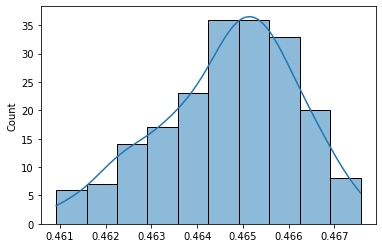

In [41]:
import seaborn as sns
s = pd.Series(ranks)

mrrs = []
for i in range(200):
    mrrs.append(
        (1.0/(1+s.sample(frac=1, replace=True))).mean()
    )
    
sns.histplot(mrrs, kde=True)